# Run CoCiP with FDR or QAR data

## References
- Schumann, U. “A Contrail Cirrus Prediction Model.” Geoscientific Model Development 5, no. 3 (May 3, 2012): 543–80. https://doi.org/10.5194/gmd-5-543-2012.
- EASA: ICAO Aircraft Engine Emissions Databank (07/2021), 2021. 
- ICAO: Annex 16: Environmental Protection - Volume II - Aircraft Engine Emissions: https://store.icao.int/en/annex-16-environmental-protection-volume-ii-aircraft-engine-emissions, 2008. Last access: 18 August 2022. 

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from pycontrails import Flight
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocip import Cocip
from pycontrails.models.emissions import Emissions
from pycontrails.models.humidity_scaling import HistogramMatching
from pycontrails.models.ps_model import PSFlight

## Download met data

In [2]:
time_bounds = ("2022-03-01 00:00:00", "2022-03-01 23:00:00")
pressure_levels = (300, 250, 200)  # 30,000 ft to 38,000 ft

era5pl = ERA5(
    time=time_bounds,
    variables=Cocip.met_variables + Cocip.optional_met_variables,
    pressure_levels=pressure_levels,
)
era5sl = ERA5(time=time_bounds, variables=Cocip.rad_variables)

# download data from ERA5 (or open from cache)
met = era5pl.open_metdataset()
rad = era5sl.open_metdataset()

## Read in data and resample

In this example, the sample data provides TAS, aircraft mass, and fuel flow per engine. Any values provided as input to the CoCiP model will not be overwritten when CoCiP is run, and so we should make sure we are saving the most accurate portions of the FDR data. Typically, thurst values provided by FDRs are noisy and innaccurate and so it is recommended to drop the thrust value if provided and recompute thrust through an aircraft performance model (below).

In this case, fuel flow is provided per engine, and so total fuel flow must be computed by summing the two values together. 

Here we are also resampling the FDR data to a one minute sampling period, which is recommended when running CoCiP.  Note that the `resample_and_fill` function will interpolate time, position, and altitude, but for the remaining columns, it will simply choose the nearsest value. There are much more accurate ways to resample fuel flow data, but this should generally be sufficient to estimate contrail impacts.

In [3]:
attrs = {
    "flight_id": "test",
    "aircraft_type": "B77W",
    "engine_uid": "01P21GE217",  # 01P21GE217 -> GE90-115B
    # "n_engine":2 # This shouldn't be needed?
}

df = pd.read_csv("data/flight-fdr.csv")
df["fuel_flow"] = df["fuel_flow_1"] + df["fuel_flow_2"]  # Checked
fl = Flight(df, attrs=attrs)

fl = fl.resample_and_fill(freq="60s", drop=False)
fl

Flight [10 keys x 136 length, 4 attributes]
	Keys: longitude, latitude, altitude, flight_id, true_airspeed, ..., time
	Attributes:
	time                [2022-03-01 00:15:00, 2022-03-01 02:30:00]
	longitude           [-39.926, -25.0]
	latitude            [34.0, 39.97]
	altitude            [10900.0, 10900.0]
	flight_id           test
	aircraft_type       B77W
	engine_uid          01P21GE217
	crs                 EPSG:4326

## (Optional) Run Aircraft Performance Model
The `CoCiP` module will automatically run an aircraft performance model to compute any missing values needed.  In this case, we still need to compute engine efficiency and estimated thrust force.  For completeness, we show how this can be computed directly from the an aircraft performance model.

In [4]:
perf = PSFlight(met=met)
fp = perf.eval(fl)

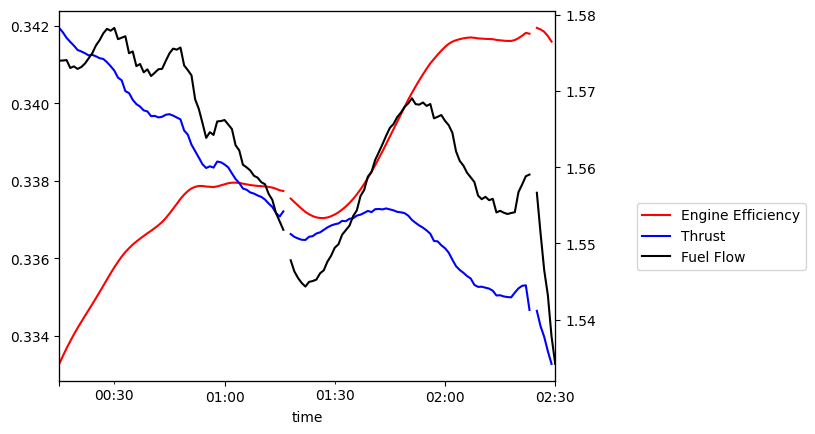

In [5]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax3 = ax2.twinx()
ax2.set_yticks([])
fp.dataframe.plot(ax=ax, x="time", y="engine_efficiency", style="r", legend=False)
fp.dataframe.plot(ax=ax2, x="time", y="thrust", style="b", legend=False)
fp.dataframe.plot(ax=ax3, x="time", y="fuel_flow", style="k", legend=False)
_ = ax3.legend(
    [ax.get_lines()[0], ax2.get_lines()[0], ax3.get_lines()[0]],
    ["Engine Efficiency", "Thrust", "Fuel Flow"],
    bbox_to_anchor=(1.15, 0.5),
)

## Compute Aircraft Emissions
Given fuel flow data, met data, aircraft, and engine type, we have sufficient information to run the emissions module and compute nvPM estimates needed as input for CoCiP.  We have not specified engine type, so in the case, the default engine type will be assumed, which for the `B77W` is the `GE-90 115B`.  To specific a different engine type, add the key `engine_uid` to the `attrs` dict when creating the `Flight` object.

Note that the emissions module estimates the aircraft thrust setting by comparing the fuel flow to the maximum fuel flow.  This is the perferred way to estimate emissions using the ICAO emissions inventory and is the default behavior of the emissions module even when aircraft thrust is provided in the input.

In [6]:
emissions = Emissions(met=met, humidity_scaling=HistogramMatching())
fl = emissions.eval(fl)
fl

Flight [31 keys x 136 length, 17 attributes]
	Keys: longitude, latitude, altitude, flight_id, true_airspeed, ..., nvpm_number
	Attributes:
	time                [2022-03-01 00:15:00, 2022-03-01 02:30:00]
	longitude           [-39.926, -25.0]
	latitude            [34.0, 39.97]
	altitude            [10900.0, 10900.0]
	flight_id           test
	aircraft_type       B77W
	engine_uid          01P21GE217
	crs                 EPSG:4326
	n_engine            2
	gaseous_data_source FFM2
	nvpm_data_source    ICAO EDB
	total_co2           39390.76441156896
	total_h2o           15337.3346711712
	total_so2           14.963253337727998
	total_sulphates     0.30537251709648977
	total_oc            0.2493875556288
	total_nox           192.979281298076
	total_co            2.915210297723201
	total_hc            0.6230983842461807
	total_nvpm_mass     0.18164446517898938
	total_nvpm_number   3.54753797881968e+18

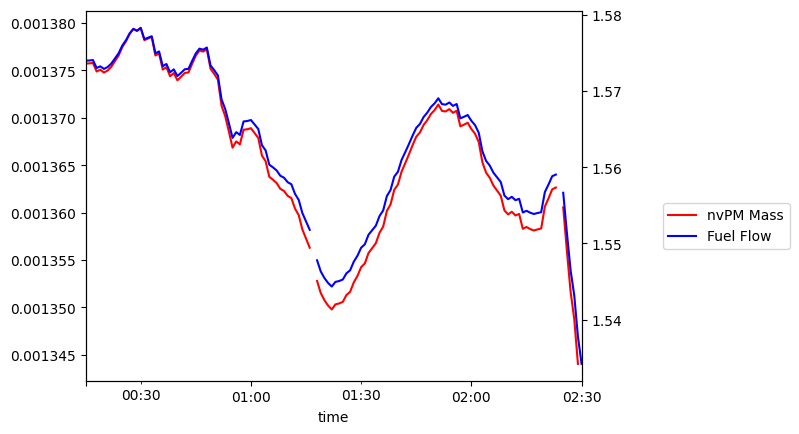

In [7]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
fl.dataframe.plot(ax=ax, x="time", y="nvpm_mass", style="r", legend=False)
fl.dataframe.plot(ax=ax2, x="time", y="fuel_flow", style="b", legend=False)
ax2.legend(
    [
        ax.get_lines()[0],
        ax2.get_lines()[0],
    ],
    ["nvPM Mass", "Fuel Flow"],
    bbox_to_anchor=(1.15, 0.5),
)

## Run CoCiP over the flight
In order to predict contrail impact, we still need an estimate of engine efficiency, which is needed to determine if the Schmidt-Appleman Criteria is satisfied.  If we provide the `CoCiP` module with an aircraft performance model, in this case the Poll-Schumann model, then this value will be estimated for us.  

In the code below, the `CoCiP` module will run the Poll-Schmann model over the flight using the provided aircraft mass in order to estimate the thrust force required for the plane to fly the specified trajectory.  This value will then be used along with the provided fuel flow data to estimate engine efficiency.  Fuel flow and emissions numbers will not be recomputed here, and the warning from `aircraft_performance.py` can be ignored --- three iterations of the performance model are only needed to estimate aircraft mass, which in this case is taken from the FDR data. 

In [8]:
cocip = Cocip(
    met=met, rad=rad, aircraft_performance=PSFlight(), humidity_scaling=HistogramMatching()
)
fl = cocip.eval(fl)
fl

Flight [67 keys x 136 length, 25 attributes]
	Keys: waypoint, longitude, latitude, altitude, flight_id, ..., cocip
	Attributes:
	time                [2022-03-01 00:15:00, 2022-03-01 02:30:00]
	longitude           [-39.926, -25.0]
	latitude            [34.0, 39.97]
	altitude            [10900.0, 10900.0]
	flight_id           test
	aircraft_type       B77W
	engine_uid          01P21GE217
	crs                 EPSG:4326
	n_engine            2
	gaseous_data_source FFM2
	nvpm_data_source    ICAO EDB
	total_co2           39390.76441156896
	total_h2o           15337.3346711712
	total_so2           14.963253337727998
	total_sulphates     0.30537251709648977
	total_oc            0.2493875556288
	total_nox           192.979281298076
	total_co            2.915210297723201
	total_hc            0.6230983842461807
	total_nvpm_mass     0.18164446517898938
	total_nvpm_number   3.54753797881968e+18
	aircraft_performance_modelPSFlight
	wingspan            64.8
	max_mach            0.89
	max_altitude        13136.880000000001
	total_fuel_burn     12469.37778144
	humidity_scaling_namehistogram_matching
	humidity_scaling_formulaera5_quantiles -> iagos_quantiles
	pycontrails_version 0.49.3.dev50

## Visualize Contrail Impact
First, we plot cumulative EF by flight waypoint (one minute sample period)

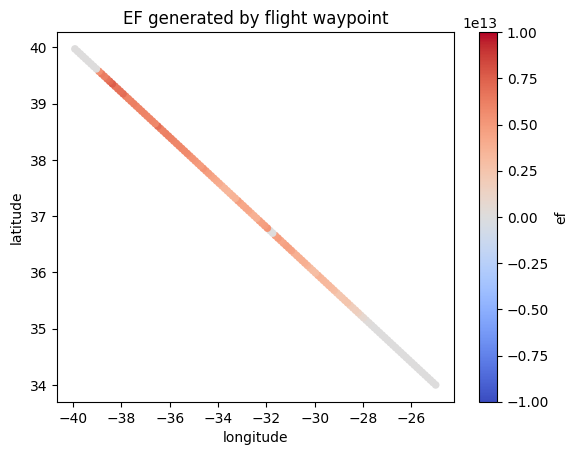

In [9]:
fl.dataframe.plot.scatter(
    x="longitude",
    y="latitude",
    c="ef",
    cmap="coolwarm",
    vmin=-1e13,
    vmax=1e13,
    title="EF generated by flight waypoint",
);

Next, we plot the evolution of the contrail as it advects along each flight segment

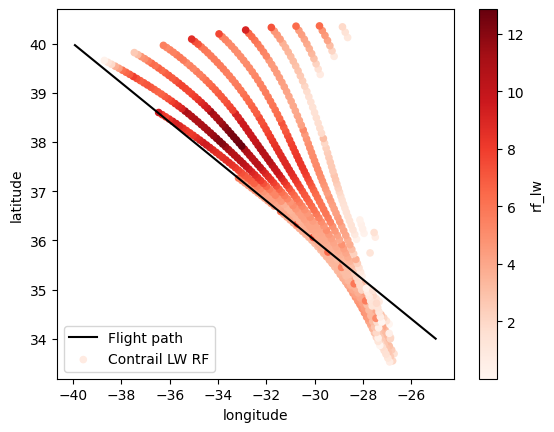

In [10]:
ax = plt.axes()

cocip.source.dataframe.plot(
    "longitude",
    "latitude",
    color="k",
    ax=ax,
    label="Flight path",
)
cocip.contrail.plot.scatter(
    "longitude",
    "latitude",
    c="rf_lw",
    cmap="Reds",
    ax=ax,
    label="Contrail LW RF",  # Contrail age?
)
ax.legend();